In [ ]:
# TODO: separate train/val set and test set before preprocessing

In [1]:
import sys
import os
import datetime as dt
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import precision_recall_fscore_support


# TODO: change path name
sys.path.append("/home/bchau/Math_156_temp/Final_Project/preprocessing/")
from preprocessing import EuroSATDataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# TODO: change path name
# setting paths to EuroSAT data and preprocessing statistics
data_path = '/home/bchau/Math_156_temp/Final_Project/EuroSAT_RGB'
preprocessing_stats_path = '/home/bchau/Math_156_temp/Final_Project/preprocessing/preprocessing_stats.pkl'
checkpoint_path = '/home/bchau/Math_156_temp/Final_Project/checkpoints'

In [4]:
# getting eurosat dataset
eurosat = EuroSATDataset(data_path, preprocessing_stats_path, transform=True)
classes = eurosat.sorted_class_names

In [5]:
# splitting dataset into train, validation, and test
generator = torch.Generator().manual_seed(0)
train_val_set, test_set = random_split(eurosat, [0.8, 0.2], generator = generator)
train_set, val_set = random_split(train_val_set, [0.8, 0.2], generator = generator)

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3)
        self.pooling = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x) 
        x = self.pooling(x)
        x = self.batch_norm(x) 
        x = self.relu(x) 
        return x

In [7]:
class FullyConnectedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_output=False):
        super().__init__()
        self.is_output = is_output
        self.conv = nn.Linear(in_channels, out_channels)
        if not self.is_output:
            self.batch_norm = nn.BatchNorm1d(out_channels)
            self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        if not self.is_output: 
            x = self.batch_norm(x)
            x = self.relu(x)
        return x

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvBlock(3, 8)
        self.conv_block2 = ConvBlock(8, 12)
        self.conv_block3 = ConvBlock(12, 16)
        flatten_channels = 16 * 6 * 6
        self.fc_block1 = FullyConnectedBlock(flatten_channels, flatten_channels // 2)
        self.fc_block2 = FullyConnectedBlock(flatten_channels // 2, 10, is_output=True)
        self.conv_blocks = nn.Sequential(
            self.conv_block1, 
            self.conv_block2, 
            self.conv_block3
        )
        self.fc_blocks = nn.Sequential(
            self.fc_block1, 
            self.fc_block2
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        #  flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        x = self.fc_blocks(x)
        return x
    
test_model = Net()
test_img = torch.rand((10, 3, 64, 64))
test_model(test_img).shape

torch.Size([10, 10])

In [22]:
# Initializing model
model_name = 'cnn' # name of model (for checkpoint file name)
model = Net().to(device)

In [23]:
# TODO: setting hyperparameters
batch_size = 64
epochs = 20 
optimizer = torch.optim.SGD(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# containers for storing loss data and epoch times
train_loss = []
train_loss_idx = []
val_loss = []
val_acc = []
val_loss_idx = []
epoch_times = []

# tracking when to checkpoint model
checkpoint_after_epochs = 5

In [24]:
# creating dataloaders
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size)

In [25]:
# Testing loss
for data in train_loader:
    imgs = data['image'].to(device)
    labels = data['land_use'].to(device)
    print(imgs.shape)
    print(imgs.dtype)
    print(labels.shape)
    print(labels.dtype)
    test_output = model(imgs)
    print(test_output.dtype)
    print(torch.nn.CrossEntropyLoss()(test_output, labels))
    break

torch.Size([64, 3, 64, 64])
torch.float32
torch.Size([64])
torch.int64
torch.float32
tensor(2.4200, device='cuda:0', grad_fn=<NllLossBackward0>)


In [26]:
def train_one_epoch(epoch_index, optimizer, loss_fn, train_loader, model, 
                    train_loss, train_loss_idx):
    running_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs = data['image'].to(device)
        labels = data['land_use'].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather training batch loss and report
        running_loss += loss.item()
        if i % 90 == 89:
            last_loss = running_loss / 90 # loss per batch
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print('{} batch {} loss: {}'.format(timestamp, i + 1, last_loss))
            train_loss_idx.append(epoch_index * len(train_loader) + i + 1)
            train_loss.append(last_loss)
            running_loss = 0.

    return last_loss

In [27]:
def save_checkpoint(epoch, optimizer, loss_fn, model, 
               train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, status):
    model_path = os.path.join(checkpoint_path, f'{status}_{model_name}_e{epoch}.tar')
    result = {
        'epoch': epoch, 
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_fn': loss_fn, 
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss, 
        'train_loss_idx': train_loss_idx, 
        'val_loss': val_loss, 
        'val_acc': val_acc,
        'val_loss_idx': val_loss_idx
    }
    timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
    print(f'{timestamp} Saving results at {checkpoint_path}')
    torch.save(result, model_path)

In [28]:
def load_checkpoint(checkpoint_path, model_type, optimizer_type=None):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model_type.load_state_dict(checkpoint['model_state_dict'])
    # returns all training information if optimizer is provided
    if optimizer_type:
        optimizer_type.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch = checkpoint['epoch']
        loss_fn = checkpoint['loss_fn']
        train_loss = checkpoint['train_loss']
        train_loss_idx = checkpoint['train_loss_idx']
        val_loss = checkpoint['val_loss']
        val_acc = checkpoint.get('val_acc', None)
        val_loss_idx = checkpoint['val_loss_idx']
        return (model_epoch, optimizer_type, loss_fn, model_type, 
                train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)
    # otherwise only return model
    return model_type

In [ ]:
def train_model(epochs, optimizer, loss_fn, train_loader, model):
    best_vloss = torch.inf 
    for epoch in range(epochs):
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Epoch {epoch}/{epochs}")

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        epoch_start_time = time.time()
        avg_loss = train_one_epoch(epoch, optimizer, loss_fn, train_loader, model, train_loss, train_loss_idx)
        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)

        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Finished training in {str(dt.timedelta(seconds = epoch_times[-1]))}")

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        running_vloss = 0.0
        running_vacc = 0.
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs = vdata['image'].to(device)
                vlabels = vdata['land_use'].to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                vpred = torch.argmax(voutputs, dim=1)
                vacc = (torch.sum(vlabels == vpred) / len(vlabels))
                running_vacc += vacc.item()

        avg_vloss = running_vloss / (i + 1)
        avg_vacc = running_vacc / (i + 1)
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print('{} LOSS train {} valid {}'.format(timestamp, avg_loss, avg_vloss))

        # Log the validation running loss averaged per batch
        val_loss_idx.append(len(train_loader) * (epoch + 1))
        val_loss.append(avg_vloss)
        val_acc.append(avg_vacc)

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print(f"{timestamp} New best validation loss: {best_vloss}")
            save_checkpoint(epoch + 1, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'best')
        elif epoch % checkpoint_after_epochs == checkpoint_after_epochs - 1:
            save_checkpoint(epoch + 1, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
        
        print('=================================')

    save_checkpoint(epoch + 1, optimizer, loss_fn, model, 
                    train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
    return model

In [ ]:
model = train_model(epochs, optimizer, loss_fn, train_loader, model)

2025-03-09 21-18-14 Epoch 0/20
2025-03-09 21-18-31 batch 90 loss: 2.2054890937275355
2025-03-09 21-18-48 batch 180 loss: 1.9987063977453443
2025-03-09 21-19-05 batch 270 loss: 1.8768855068418715
2025-03-09 21-19-05 Finished training in 0:00:51.290128
2025-03-09 21-19-16 LOSS train 1.8768855068418715 valid 8.440964972271638
2025-03-09 21-19-16 New best validation loss: 8.440964972271638
2025-03-09 21-19-16 Saving results at /home/bchau/Math_156_temp/Final_Project/checkpoints
2025-03-09 21-19-16 Epoch 1/20
2025-03-09 21-19-33 batch 90 loss: 1.7924646602736578
2025-03-09 21-19-50 batch 180 loss: 1.712035690413581
2025-03-09 21-20-06 batch 270 loss: 1.6369647807545131
2025-03-09 21-20-06 Finished training in 0:00:49.741807
2025-03-09 21-20-17 LOSS train 1.6369647807545131 valid 5.516801841118756
2025-03-09 21-20-17 New best validation loss: 5.516801841118756
2025-03-09 21-20-17 Saving results at /home/bchau/Math_156_temp/Final_Project/checkpoints
2025-03-09 21-20-17 Epoch 2/20
2025-03-09 2

In [ ]:
# Evaluating Model on Test Set

In [31]:
def test_model(data_loader, model):
    all_labels = torch.zeros(len(data_loader.dataset))
    all_predictions = torch.zeros(len(data_loader.dataset))
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            inputs = data['image'].to(device)
            labels = data['land_use'].cpu()
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1).cpu()
            start_idx = i * data_loader.batch_size
            if i != len(data_loader) - 1:
                end_idx = start_idx + data_loader.batch_size
            else:
                end_idx = start_idx + len(labels)
                assert(end_idx == len(data_loader.dataset))
            all_labels[start_idx:end_idx] = labels
            all_predictions[start_idx:end_idx] = predictions 

    metrics = pd.DataFrame(columns=['Precision', 'Recall', 'F1_Score'])
    
    micro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='micro', zero_division='warn')
    macro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='macro', zero_division='warn')
    accuracy = torch.sum(all_labels == all_predictions) / len(all_labels)
    metrics.loc['Micro Avg'] = micro_avg[:3]
    metrics.loc['Macro Avg'] = macro_avg[:3]
    metrics.loc['Accuracy'] = [accuracy.item(), None, None]

    return metrics

In [66]:
latest_model_path = os.path.join(checkpoint_path, 'latest_cnn_e20.tar')
checkpoint_model = Net()
checkpoint_model = load_checkpoint(latest_model_path, checkpoint_model).to(device)

In [67]:
metrics = test_model(test_loader, checkpoint_model)

100%|██████████| 85/85 [00:15<00:00,  5.36it/s]


In [68]:
metrics

,Precision,Recall,F1_Score
Micro Avg,0.768333,0.768333,0.768333
Macro Avg,0.755775,0.760756,0.756312
Accuracy,0.768333,NaN,NaN


In [69]:
def plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx):
    fig, ax = plt.subplots()
    ax.plot(train_loss_idx, train_loss, color='blue', label='Training Loss')
    ax.plot(np.array(val_loss_idx), val_loss, color='orange', label='Val Loss')
    ax.plot(np.array(val_loss_idx), val_acc, color='orange', linestyle='dashed', label='Val Acc')
    ax.legend()
    return fig

In [70]:
for i, item in enumerate(val_acc):
    val_acc[i] = item.item()

AttributeError: 'float' object has no attribute 'item'

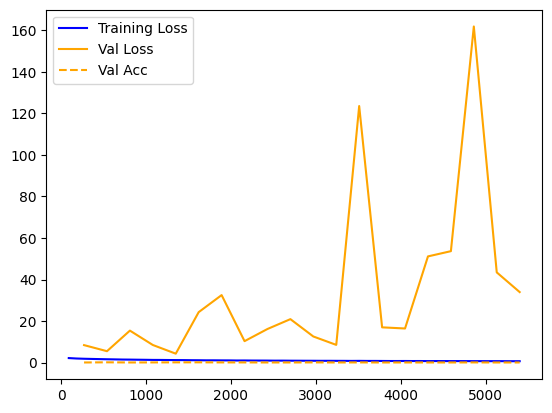

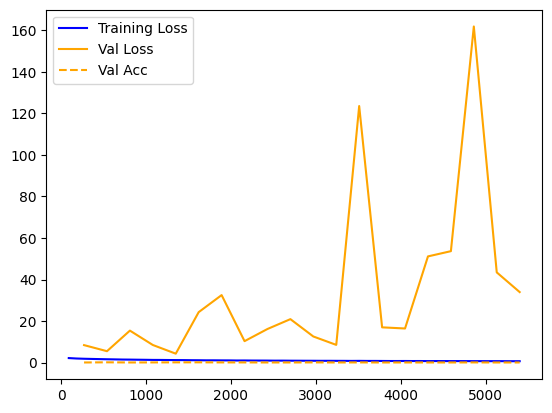

In [71]:
plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)

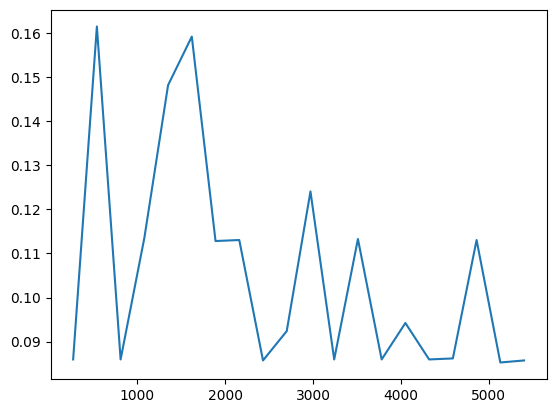

In [72]:
fig, ax = plt.subplots()
ax.plot(val_loss_idx, val_acc)

In [73]:
running_vloss = 0.
running_vacc = 0.
with torch.no_grad():
    for i, vdata in enumerate(val_loader):
        vinputs = vdata['image'].to(device)
        vlabels = vdata['land_use'].to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()

        vpred = torch.argmax(voutputs, dim=1)
        vacc = (torch.sum(vlabels == vpred) / len(vlabels)).item()
        running_vacc += vacc

In [74]:
running_vloss / (i + 1)

33.95571279525757

In [75]:
running_vacc / len(val_loader)

0.0857077205882353

In [76]:
vacc

0.0625

In [77]:
running_tloss = 0.
running_tacc = 0.
with torch.no_grad():
    for i, vdata in enumerate(test_loader):
        vinputs = vdata['image'].to(device)
        vlabels = vdata['land_use'].to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_tloss += vloss.item()

        vpred = torch.argmax(voutputs, dim=1)
        vacc = (torch.sum(vlabels == vpred) / len(vlabels)).item()
        running_tacc += vacc

In [78]:
running_tloss / (i + 1)

33.559736184512865

In [79]:
running_tacc / (i + 1)

0.09044117647058823

# Figure out why validation loss is wacky 

In [101]:
sorted(os.listdir(checkpoint_path))

['best_cnn_e1.tar',
 'best_cnn_e2.tar',
 'best_cnn_e5.tar',
 'first_run',
 'latest_cnn_e10.tar',
 'latest_cnn_e15.tar',
 'latest_cnn_e20.tar']

1


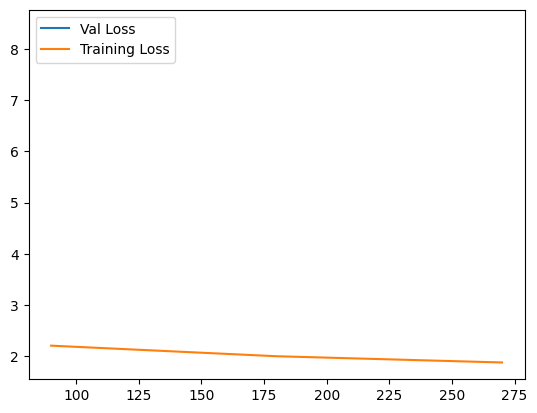

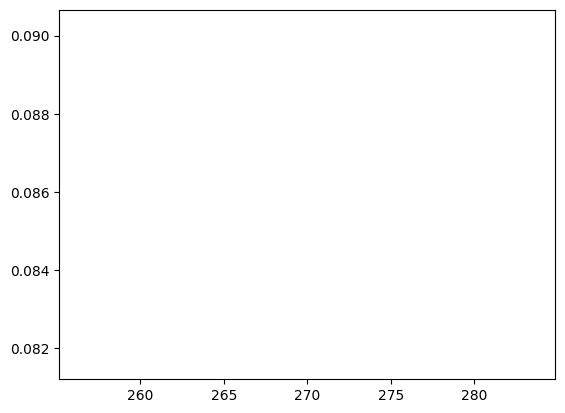

2


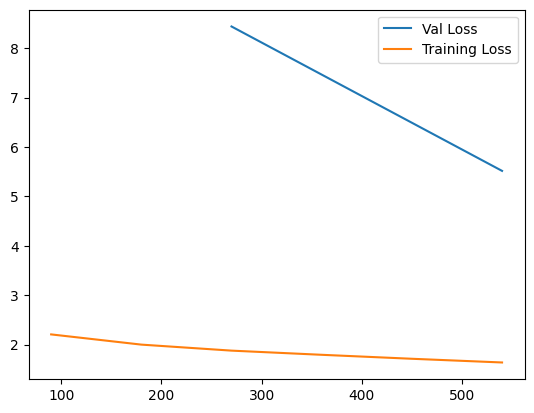

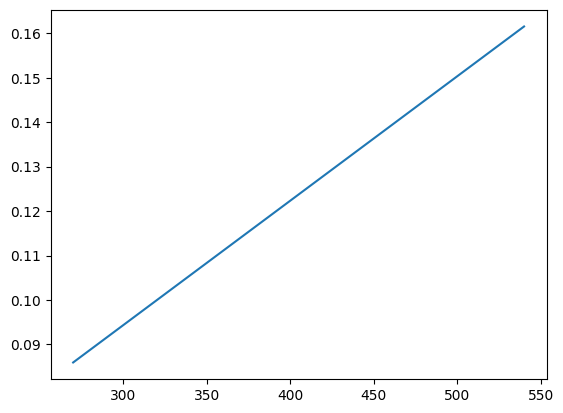

5


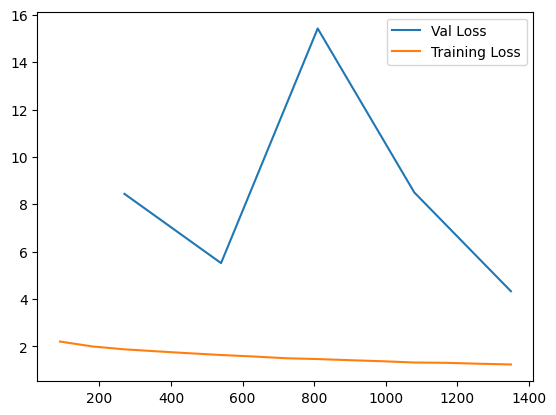

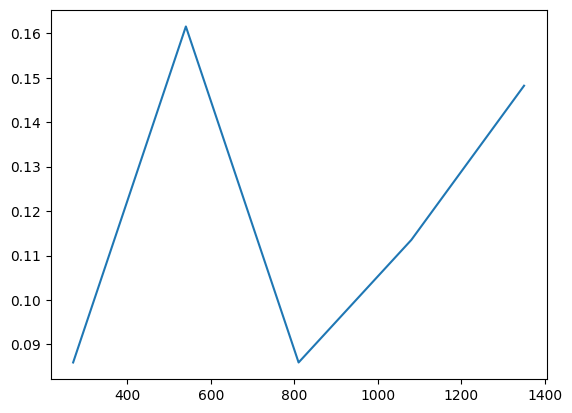

10


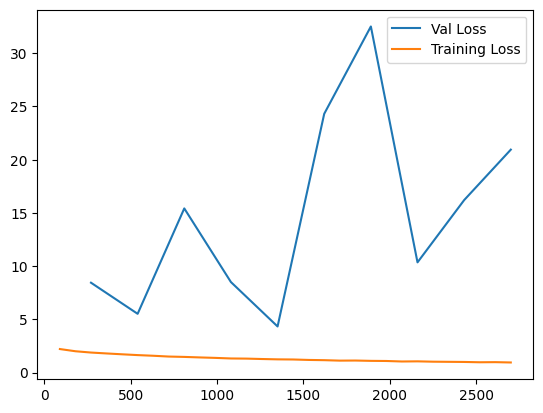

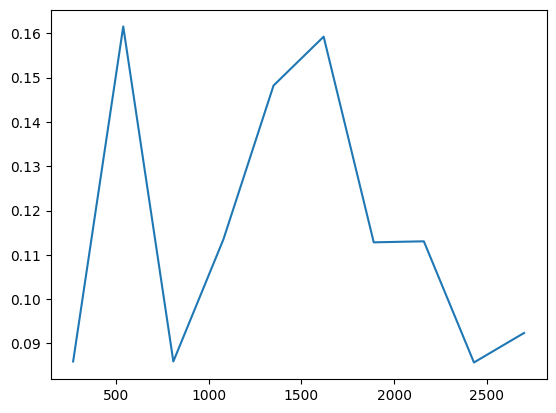

15


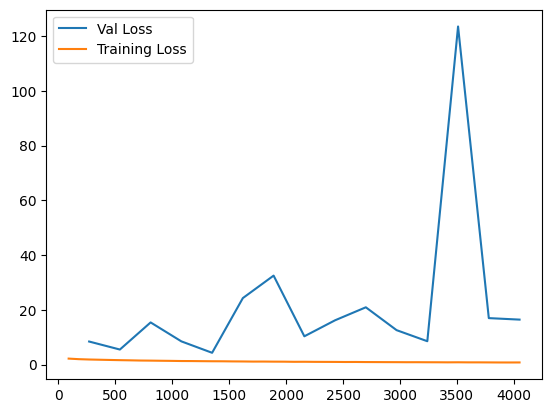

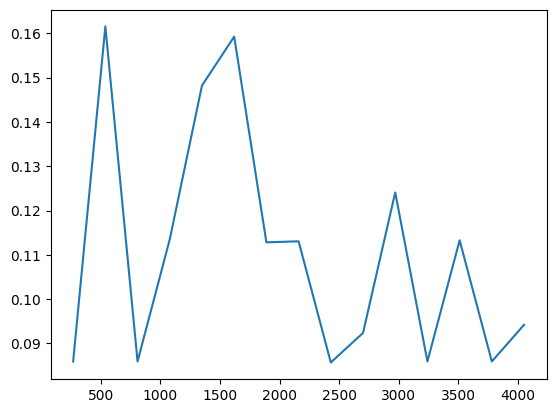

20


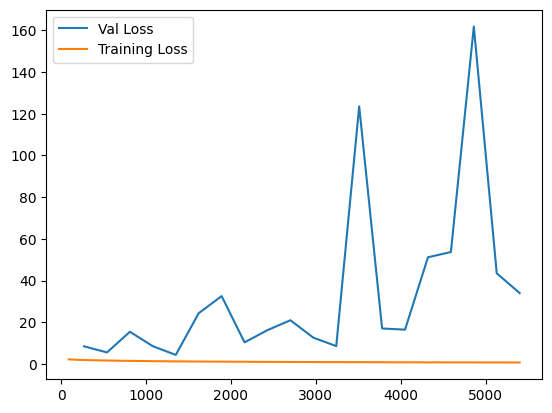

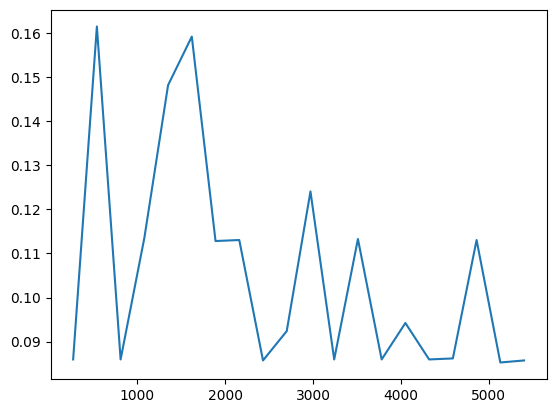

In [ ]:
for model_name in sorted(os.listdir(checkpoint_path)):
    if '.tar' not in model_name:
        continue
    model_path = os.path.join(checkpoint_path, model_name)
    checkpoint_model = Net()
    checkpoint_optim = torch.optim.SGD(checkpoint_model.parameters())
    (model_epoch, checkpoint_optim, _, checkpoint_model, 
     train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx) = load_checkpoint(model_path, checkpoint_model, checkpoint_optim)
    checkpoint_model = checkpoint_model.to(device)

    print(model_epoch)

    # TODO: maybe try testing each of the models at different epochs and recalculate their accuracy and val loss?
    

In [118]:
running_vloss = 0.
with torch.no_grad():
    for i, vdata in enumerate(val_loader):
        vinputs = vdata['image'].to(device)
        vlabels = vdata['land_use'].to(device)
        voutputs = checkpoint_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()

In [120]:
val_loss_idx

[1, 271, 541, 811, 1081, 1351, 1621, 1891, 2161, 2431, 2701]

In [121]:
val_loss

[tensor(4.1712),
 tensor(2.4189),
 tensor(2.9760),
 tensor(117.3983),
 tensor(9.2089),
 tensor(11.0979),
 tensor(15.8019),
 tensor(8.6846),
 tensor(116.2095),
 tensor(22.2975),
 tensor(119.6928)]

In [119]:
avg_vloss = running_vloss / i 
avg_vloss

0.8857927375764989

In [ ]:
# TODO: grid search specific to CNN, googlenet, mobilenet